In [1]:
import pandas as pd

In [2]:
train_labels = pd.read_csv('../../data/train_labels.csv')


In [3]:
!ls -al ../../data

总用量 1348
drwxrwxr-x.  4 p303872 p303872   4096 7月  10 11:13 .
drwxrwxr-x.  4 p303872 p303872   4096 7月  10 10:39 ..
-rw-r-----.  1 p303872 p303872 609409 5月   6 06:45 sample_submission.csv
drwxr-x---. 18 p303872 p303872   4096 5月   6 18:49 test
drwxr-x---. 18 p303872 p303872   4096 5月   6 19:36 train
-rw-r-----.  1 p303872 p303872 752485 5月   6 06:56 train_labels.csv


In [4]:
train_labels['img_path']=train_labels['id'].apply(lambda x: f'../../data/train/{x[0]}/{x}.npy')

In [5]:
train_labels[train_labels.target==1]

,id,target,img_path
20,001c619bdf53,1,../../data/train/0/001c619bdf53.npy
33,0030dc7cf6e0,1,../../data/train/0/0030dc7cf6e0.npy
34,003147674cb9,1,../../data/train/0/003147674cb9.npy
41,003869e291cd,1,../../data/train/0/003869e291cd.npy
44,003b6e82e852,1,../../data/train/0/003b6e82e852.npy
...,...,...,...
50127,ffc70eefe8c6,1,../../data/train/f/ffc70eefe8c6.npy
50143,ffde38ad6974,1,../../data/train/f/ffde38ad6974.npy
50147,ffe076c0181c,1,../../data/train/f/ffe076c0181c.npy
50148,ffe34e46aee9,1,../../data/train/f/ffe34e46aee9.npy


In [6]:
train_labels[train_labels.target==1]['img_path'].values[0]

'../../data/train/0/001c619bdf53.npy'

In [7]:
import numpy as np
data = np.load(train_labels[train_labels.target==1]['img_path'].values[0]).astype(np.float32)
data = np.vstack(data).transpose((1,0))

Populating the interactive namespace from numpy and matplotlib


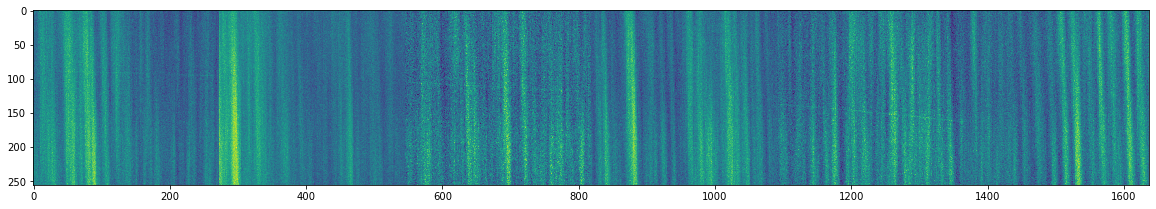

In [8]:
import matplotlib.pyplot as plt
%pylab inline
plt.figure(figsize=(20,10))
plt.imshow(data)

In [47]:
data[:,np.newaxis,:].shape

(256, 1, 1638)

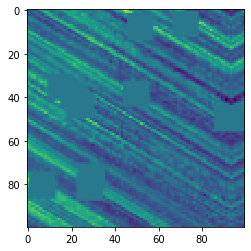

In [18]:
import albumentations
from albumentations.pytorch import ToTensorV2

# params
def get_train_transforms():
    return albumentations.Compose(
        [
            albumentations.Resize(100,100),
            albumentations.HorizontalFlip(p=0.5),
            albumentations.VerticalFlip(p=0.5),
            albumentations.Rotate(limit=180, p=0.7),
            albumentations.RandomBrightness(limit=0.6, p=0.5),
            albumentations.Cutout(
                num_holes=10, max_h_size=12, max_w_size=12,
                fill_value=0, always_apply=False, p=0.5
            ),
            albumentations.ShiftScaleRotate(
                shift_limit=0.25, scale_limit=0.1, rotate_limit=0
            ),
#            albumentations.OneOf([
#                GridMask(num_grid=3, mode=0, rotate=15),
#                GridMask(num_grid=3, mode=2, rotate=15),
#                                ], p=0.7),
            ToTensorV2(p=1.0),
        ]
    )
plt.imshow(np.array(get_train_transforms()(image=data)["image"])[0])

Populating the interactive namespace from numpy and matplotlib


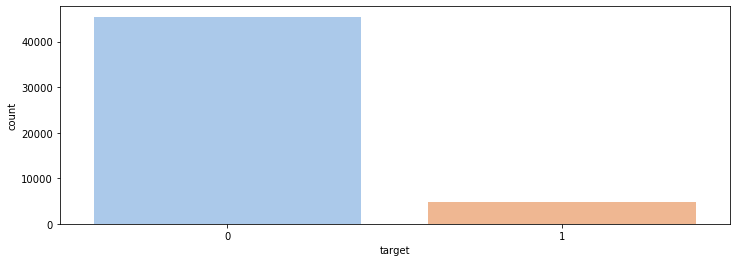

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
%pylab inline
fig,ax = plt.subplots(1,1,figsize=(12,4))
sns.countplot(data=train_labels,x='target',orient = "v", palette = 'pastel', ax = ax)

In [14]:
def get_train_filename_by_id(_id: str) -> str:
    return f"../../data/train/{_id[0]}/{_id}.npy"

def show_cadence(filename: str, label: int) -> None:
    fig, axes = plt.subplots(6, 1, figsize = (16, 10))
    ax = axes.ravel()
    arr = np.load(filename)
    for i in range(6):
        
        ax[i].imshow(arr[i].astype(float), interpolation='nearest', aspect='auto')
        ax[i].text(5, 100, ["ON", "OFF"][i % 2], bbox={'facecolor': 'white'})
        if i != 5:
            ax[i].set_xticks([])
            
    fig.text(0.5, -0.02, 'Frequency Range', ha='center', fontsize=18)
    fig.text(-0.02, 0.5, 'Seconds', va='center', rotation='vertical', fontsize=18)

    plt.suptitle(f"ID: {os.path.basename(filename)} TARGET: {label}", fontsize=18)
    fig.tight_layout()
    plt.show()
show_cadence(np.random.choice(train_labels, 1).item(), None)


ValueError: a must be 1-dimensional

Populating the interactive namespace from numpy and matplotlib


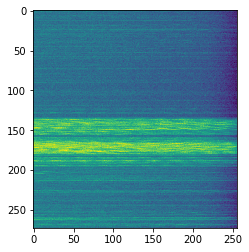

In [12]:
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
arr = np.load(train_labels['img_path'].iloc[0])
plt.imshow(arr[1,:,:].astype(float))

In [6]:
import torch
class ClassificationDataset():
    def __init__(self,image_paths,targets):
        self.image_paths = image_paths
        self.targets = targets
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem(self,item):
        image = np.load(self.image_path[item]).astype(float)
        targets = self.targets[item]
        return torch.tensor(image,dtype=torch.float),torch.tensor(targets,dtype=torch.long)
    

In [3]:
import torchvision.models as models
resnet18 = models.resnet18(pretrained=True)
resnet34 = models.resnet34(pretrained=True)
resnet101 = models.resnet101(pretrained=True)
densenet121 = models.densenet121(pretrained=True)
densenet161 = models.densenet161(pretrained=True)
inception = models.inception_v3(pretrained=True)
resnext50_32x4d = models.resnext50_32x4d(pretrained=True)
resnext101_32x4d = models.resnext101_32x8d(pretrained=True)


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /home/p303872/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /home/p303872/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


  0%|          | 0.00/110M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /home/p303872/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /home/p303872/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


  0%|          | 0.00/95.8M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /home/p303872/.cache/torch/hub/checkpoints/resnext101_32x8d-8ba56ff5.pth


  0%|          | 0.00/340M [00:00<?, ?B/s]

In [ ]:
data = ClassficationDataset(train_labels['img_path'].values,train_labels['target'].values)
data[0]

In [ ]:
import torch.nn as nn
class enmodel(nn.Module):
    def __init__(self,backbone,out_dim):
        super(enmodel,self).__init__()
        self.model = 
        self.fc = nn.Linear(self.model._fc.in_features,1)
        self.model._fc = nn.Identity()
        #6->3
        self.conv=nn.Conv2d(6,3,kernel_size=3,stride=1,padding=3,bias=False)
    
    def forward(self,x):
        x = self.conv(x)
        x = self.model(x)
        x = self.fc(x)

In [ ]:
criterion=nn.BCEWithLogitsLoss()

def train(data_loader,model,optimizer,device):
    model.train()
    for data in tqdm(data_loader,position=0,leave=True,desc='Training'):
        inputs,targets=data
        inputs = inputs.to(device)
        targets = targets.to(device,dtype = torch.float)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs,targets.view(-1,1))
        loss.backward()
        optimizer.step()
        print(loss.item())
device = torch.device("cuda")


In [23]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5,random_state=1024)
for train_index,test_index in skf.split(train_labels,train_labels['target'].values):
    print(train_index,test_index)
    train_images,valid_images = train_labels['img_path'].iloc[train_index].values,train_labels['img_path'].iloc[test_index].values
    train_targets,valid_targets = train_labels['target'].iloc[train_index].values,train_labels['target'].iloc[test_index].values
    model.to(device)
    train_dataset = Cl
    valid_dataset
    train_loader = 
    test_loader = 
    optimizer = torch.optim.Adam(model.parameters(),lr=5e-4)
    

[10004 10005 10006 ... 50162 50163 50164] [    0     1     2 ... 10251 10265 10267]
[    0     1     2 ... 50162 50163 50164] [10004 10005 10006 ... 20124 20136 20145]
[    0     1     2 ... 50162 50163 50164] [20059 20060 20061 ... 30100 30101 30103]
[    0     1     2 ... 50162 50163 50164] [30076 30083 30087 ... 40129 40130 40131]
[    0     1     2 ... 40129 40130 40131] [40132 40133 40134 ... 50162 50163 50164]


/software/software/scikit-learn/0.22.2.post1-fosscuda-2019b-Python-3.7.4/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [21]:
train_labels['target'][train_labels['target']==0].count()

45471

In [22]:
train_labels['target'][train_labels['target']==1].count()

4694

In [ ]:
from sklearn.metrics import auc

best_auc = 0

if val_auc>best_auc:
    torch.save(model.state_dict(),'b')
    best_auc = val_auc